In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline

generate_new_data = False # just toggles the slowest (multi-mode, non-celery) simulation

In [2]:
omega = 2. * np.pi / (5.4 * 60.) # s^-1 ; ang freq for 5.4 minute oscillation
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling
driving_amp = np.sqrt(0.19**2 * gamma * dt) # kick amplitude to get 19 cm/s amplitude over coherence time

In [3]:
def step_forward_matrix(omega, gamma, dt):
    # return [x, rv] after time dt
    Minv = np.linalg.inv(np.array([[1, 0], [-0.5 * gamma, omega]]))
    A = np.array([[np.cos(omega * dt),
                   np.sin(omega * dt)],
                  [-omega * np.sin(omega * dt) - 0.5 * gamma * np.cos(omega * dt),
                    omega * np.cos(omega * dt) - 0.5 * gamma * np.sin(omega * dt)]])
    A *= np.exp(-0.5 * gamma * dt)
    return np.dot(A, Minv)

In [4]:
def take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp):
    # returns x0.5, v0.5 (prediction for next observation time)
    # and x1, v1 (starting position post-kick)
    x_half, v_half = np.dot(step_half_matrix, (x0,v0))
    x_one, v_one = np.dot(step_full_matrix, (x0,v0))
    v_one += driving_amp * np.random.normal(0.,1.)
    return x_half, v_half, x_one, v_one

In [5]:
def take_many_steps(omega, gamma, dt, driving_amp, timescale=365.):
    # timescale is number of days to observe
    assert dt < np.pi / omega, "ERROR: you're not well-sampled. decrease dt."
    if dt > 0.5 * np.pi / omega: print("WARNING: your coarse time spacing makes even cubic spline risky")

    ts = dt * np.arange(timescale * 24. * 3600. / dt)
    xs = np.zeros_like(ts)
    rvs = np.zeros_like(ts)
    
    step_half_matrix = step_forward_matrix(omega, gamma, 0.5 * dt)
    step_full_matrix = step_forward_matrix(omega, gamma, dt)
    x0, v0 = 0., 0.
    for i,t in enumerate(ts):
        xs[i], rvs[i], x0, v0 = take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp)
    return ts, xs, rvs

In [6]:
dt = 1. * 60. # 1-minute cadence
timespan = 365. # 1 year
ts, xs, rvs = take_many_steps(omega, gamma, dt, driving_amp, timescale=timespan)

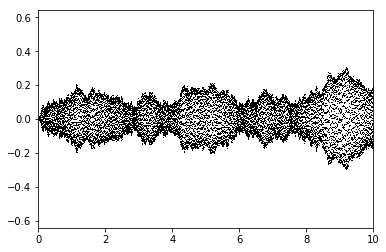

In [7]:
plt.plot(ts/86400., rvs, 'k,')
plt.xlim([0.,10.]);

Ramp-up period (only makes sense if you are initializing at exactly zero).

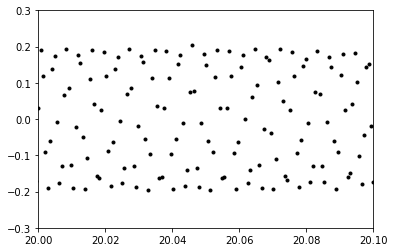

In [8]:
plt.plot(ts/86400., rvs, 'k.')
plt.xlim([20.,20.1])
plt.ylim([-0.3,0.3]);

Looks coherent over short timescales.

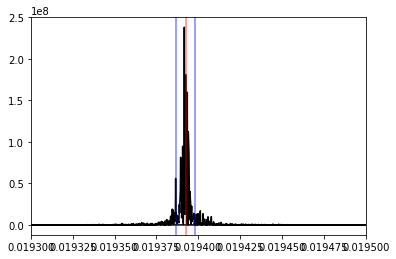

In [9]:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
omegas = np.fft.fftfreq(rvs.shape[-1]) / dt * 2. * np.pi
plt.plot(omegas, real_powers, 'k-')
plt.xlim([0.0193,0.0195])
plt.axvline(omega, alpha=0.5, c='r')
plt.axvline(omega-gamma, alpha=0.5, c='b')
plt.axvline(omega+gamma, alpha=0.5, c='b');

Tests: turning off driving and/or damping makes the FT very clean.

Hogg says that we should not calculate this on a very fine grid because numerical issues may come into play; instead, we can generate a fine grid and use cubic spline interpolation to populate it from the coarser samples (this is fine because of the Nyquist theorem which says at our sampling we already have all the necessary info).

Test this by taking the "jagged" timeseries between 20.0-20.1 days and doing an interpolation onto a much finer grid; ideally this will look like a sinusoid.

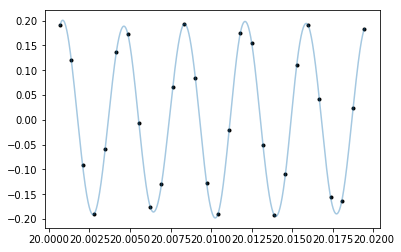

In [10]:
inds = (ts/86400. > 20.) & (ts/86400. < 20.02)
short_ts = ts[inds]
short_rvs = rvs[inds]
plt.plot(short_ts/86400., short_rvs, 'k.')
interp = interp1d(short_ts, short_rvs, kind='cubic', assume_sorted=True)
xs = np.arange(np.min(short_ts), np.max(short_ts), 0.0005)
plt.plot(xs/86400., interp(xs), alpha=0.4);

Yep!

In [11]:
def simulate_exposure(ts, rvs, start_time, exp_time):
    pad = 100. # seconds - ARBITRARY
    smaller_inds = (ts > (start_time - pad)) & (ts < (start_time + exp_time + pad))    
    interp = interp1d(ts[smaller_inds], rvs[smaller_inds], kind='cubic')
    tiny = 0.1 # 100 ms
    fine_ts = np.arange(start_time, start_time+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    return np.sum(fine_rvs)/len(fine_rvs) # ASSUMES EVEN WEIGHTING - technically incorrect for last point

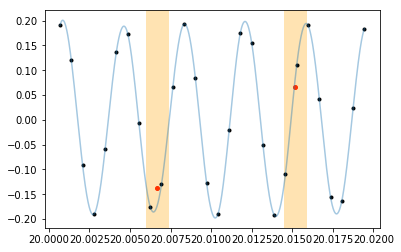

In [12]:
plt.plot(short_ts/86400., short_rvs, 'k.')
interp = interp1d(short_ts, short_rvs, kind='cubic', assume_sorted=True)
xs = np.arange(np.min(short_ts), np.max(short_ts), 0.0005)
plt.plot(xs/86400., interp(xs), alpha=0.4)
start_times = np.array([20.006, 20.0145]) * 86400. # seconds
exp_time = 120. # seconds
for st in start_times:
    plt.axvspan(st/86400., (st+exp_time)/86400., alpha=0.3, facecolor='orange')
    plt.scatter((st+exp_time/2)/86400., simulate_exposure(short_ts,short_rvs,st,exp_time),
               c='r', s=16);

#### generate the simulated data

Now do this for many modes (drawing from the envelope of modes & amplitudes in Chaplin paper) & co-add all RVs

NOTE: I made up the amplitude based on Chaplin figure because their given a_max didn't reproduce Figure 2. There must be something about powers and square roots that I'm getting wrong!

In [13]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

In [14]:
l_grid = np.append(np.zeros_like(freq_grid), np.ones_like(freq_grid))
freq_grid = np.append(freq_grid, freq_grid)
freq_grid += l_grid * 0.5 * delta_nu # Hogg!
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
amp_grid -= 0.4 * amp_grid * l_grid # Hogg!
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

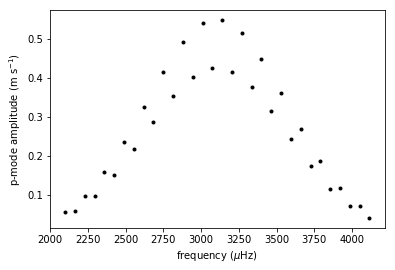

In [15]:
plt.plot(freq_grid * 1.e6, np.sqrt(amp_grid), 'k.')
plt.ylabel('p-mode amplitude (m s$^{-1}$)')
plt.xlabel('frequency ($\mu$Hz)');

In [16]:
dt = 1. * 60. # 1-minute cadence
timespan = 365. # a year

if generate_new_data:
    ts = None
    for omega, driving_amp in tqdm(zip(omega_grid,driving_amp_grid), total=len(omega_grid)):
        sim = take_many_steps(omega, gamma, dt, driving_amp, timescale=timespan)
        if ts is None: 
            ts = sim[0]
            xs = np.zeros_like(ts)
            rvs = np.zeros_like(ts)
        assert np.array_equal(sim[0], ts)
        xs += sim[1]
        rvs += sim[2]
    with open('sim_oneyear.csv', 'w') as f:
        f.write('ts,xs,rvs\n')
        for i in range(len(ts)):
            f.write('{0:.8f},{1:.8f},{2:.8f}\n'.format(ts[i],xs[i],rvs[i]))
else:
    d = np.genfromtxt('sim_oneyear.csv', names=True, dtype=None, delimiter=',')
    ts = np.copy(d['ts'])
    rvs = np.copy(d['rvs'])
    xs = np.copy(d['xs'])

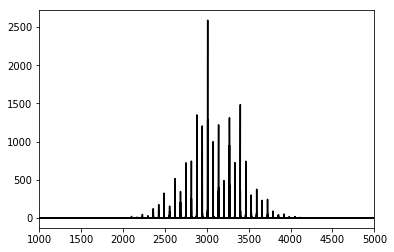

In [17]:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
fs = np.fft.fftfreq(rvs.shape[-1]) / dt
fft = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft, 'k-')
plt.xlim([1000,5000]);

Same simulation for just the strongest mode:

In [18]:
I_onemode = np.argmax(driving_amp_grid)
omega_onemode = omega_grid[I_onemode]
driving_amp_onemode = driving_amp_grid[I_onemode]
sim = take_many_steps(omega_onemode, gamma, dt, driving_amp_onemode, timescale=timespan)
ts_onemode, xs_onemode, rvs_onemode = sim

In [19]:
np.sum(ts_onemode == ts) == len(ts) # check that time grids are the same

True

0.3980290405025404

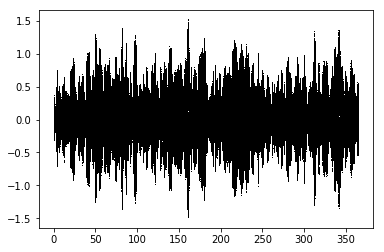

In [20]:
plt.plot(ts/86400., rvs_onemode, 'k,')
np.std(rvs_onemode)

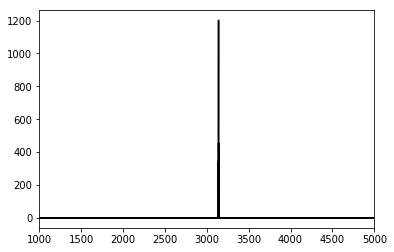

In [21]:
powers = np.fft.fft(rvs_onemode)
real_powers = (powers * powers.conj()).real
fs = np.fft.fftfreq(rvs_onemode.shape[-1]) / dt
fft_onemode = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft_onemode, 'k-')
plt.xlim([1000,5000]);

Simulate some exposure times (over a month of nightly observations) and see what the RMS is!

Note: in this case we are neglecting any sources of noise. If we were to add in photon noise then we'd probably want to compensate with more exposures per night for the shorter exposure times such that the effective SNR is the same for all cases.

In [57]:
obs_ts = np.arange(30) + 0.5 + np.random.normal(0.,2.,30)/3600. # nightly plus/minus ~2 hours (days)
obs_ts *= 24. * 3600. # seconds
exp_times = np.arange(2,65,0.25) * 60.
stds = []
for exp_time in tqdm(exp_times):
    obs_rvs = [simulate_exposure(ts_onemode, rvs_onemode, tt-exp_time/2., exp_time) for tt in obs_ts]
    stds.append(np.std(obs_rvs))

100%|██████████| 252/252 [00:23<00:00, 10.63it/s]


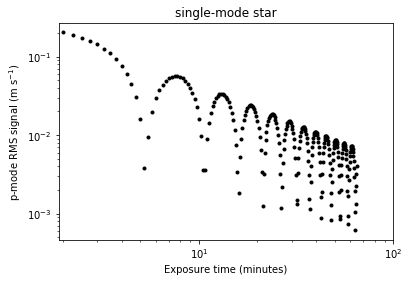

In [58]:
plt.loglog(exp_times/60., stds, 'k.')
plt.xlabel('Exposure time (minutes)')
plt.ylabel('p-mode RMS signal (m s$^{-1}$)')
plt.title('single-mode star')
plt.xlim(1.9,100);

As expected, for a single mode you really can reduce the p-mode signal by orders of magnitude if you expose at the characteristic period of that mode.

In [59]:
stds_all = []
for exp_time in tqdm(exp_times):
    obs_rvs = [simulate_exposure(ts, rvs, tt-exp_time/2., exp_time) for tt in obs_ts]
    stds_all.append(np.std(obs_rvs))

100%|██████████| 252/252 [00:23<00:00, 10.93it/s]


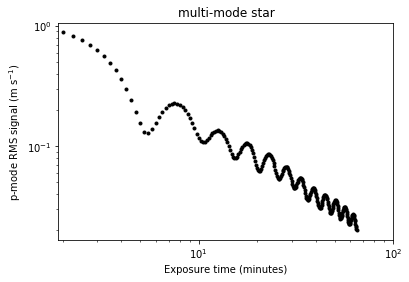

In [60]:
plt.loglog(exp_times/60., stds_all, 'k.')
plt.xlabel('Exposure time (minutes)')
plt.ylabel('p-mode RMS signal (m s$^{-1}$)')
plt.title('multi-mode star')
plt.xlim(1.9,100);

This looks a lot like the Chaplin results! Yay!

One lingering question: why does the Chaplin test with real data not have these dips? Is it because of the shorter duration over which they're averaging, as they claim?

In [61]:
readout = 30. # 30-second readout -- not sure if this should be included..
start = 10.5 * 24. * 3600. # start time in seconds
end = start + 8. * 3600. # eight hours later

In [62]:
stds_all = []
for exp_time in tqdm(exp_times):
    obs_ts_8hrs = np.arange(start, end, exp_time + readout) # uniform exposures over an 8-hour span
    obs_rvs = [simulate_exposure(ts, rvs, tt-exp_time/2., exp_time) for tt in obs_ts_8hrs]
    stds_all.append(np.std(obs_rvs))

100%|██████████| 252/252 [00:14<00:00, 16.89it/s]


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


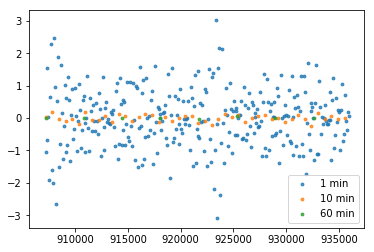

In [63]:
for exp_time in tqdm(np.array([1., 10., 60.]) * 60):
    obs_ts_8hrs = np.arange(start, end, exp_time + readout) # uniform exposures over an 8-hour span
    obs_rvs = [simulate_exposure(ts, rvs, tt-exp_time/2., exp_time) for tt in obs_ts_8hrs]  
    plt.scatter(obs_ts_8hrs, obs_rvs, label='{0:.0f} min'.format(exp_time/60.), s=8, alpha=0.8)
    
plt.legend()

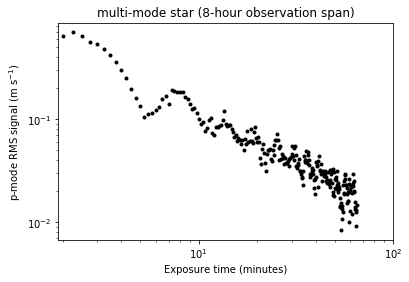

In [64]:
plt.loglog(exp_times/60., stds_all, 'k.')
plt.xlabel('Exposure time (minutes)')
plt.ylabel('p-mode RMS signal (m s$^{-1}$)')
plt.title('multi-mode star (8-hour observation span)')
plt.xlim(1.9,100);

#### simulating data with celerite 
one-mode version first:

In [30]:
import celerite as celery
celery.__version__

'0.3.1'

In [31]:
log_S0 = np.log(driving_amp_onemode**2 / (dt * omega_onemode)) # velocity variance * kicks / radian
log_Q = np.log(omega_onemode/gamma)
log_omega0 = np.log(omega_onemode)
kernel_onemode = celery.terms.SHOTerm(log_S0, log_Q, log_omega0)

In [32]:
gp = celery.GP(kernel_onemode)
gp.compute(ts_onemode)
rvs_gp_onemode = gp.sample()

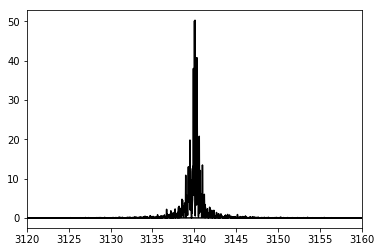

In [33]:
powers = np.fft.fft(rvs_gp_onemode)
real_powers = (powers * powers.conj()).real
fft_gp_onemode = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft_gp_onemode, 'k-')
plt.xlim([3120,3160]);

1.2529727418190397

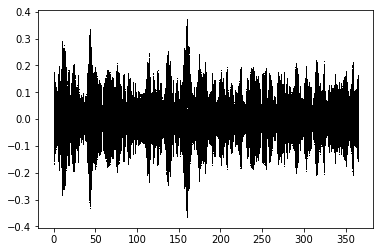

In [34]:
plt.plot(ts_onemode/86400., rvs_gp_onemode, 'k,')
#plt.xlim([0.,10.]);
#plt.ylim([-0.5,0.5]);
np.std(rvs)

525600


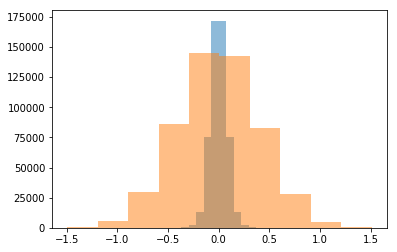

In [35]:
plt.hist(rvs_gp_onemode, alpha=0.5)
plt.hist(rvs_onemode, alpha=0.5);
print(len(rvs_onemode))

And for many modes:

In [36]:
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]
kernel = None
for o,lS in zip(omega_grid,log_S0_grid):
    if kernel is None:
        kernel = celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o))
    else:
        kernel += celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o)) 

In [37]:
gp = celery.GP(kernel)
gp.compute(ts)
rvs_gp = gp.sample()

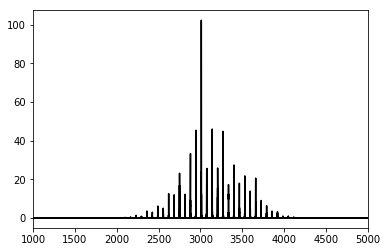

In [38]:
powers = np.fft.fft(rvs_gp)
real_powers = (powers * powers.conj()).real
fft_gp = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft_gp, 'k-')
plt.xlim([1000,5000]);

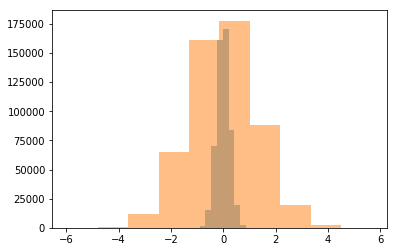

In [39]:
plt.hist(rvs_gp, alpha=0.5)
plt.hist(rvs, alpha=0.5);

There are some scaling/units issues but the FFTs generally look extremely similar to those produced by our method - yay!

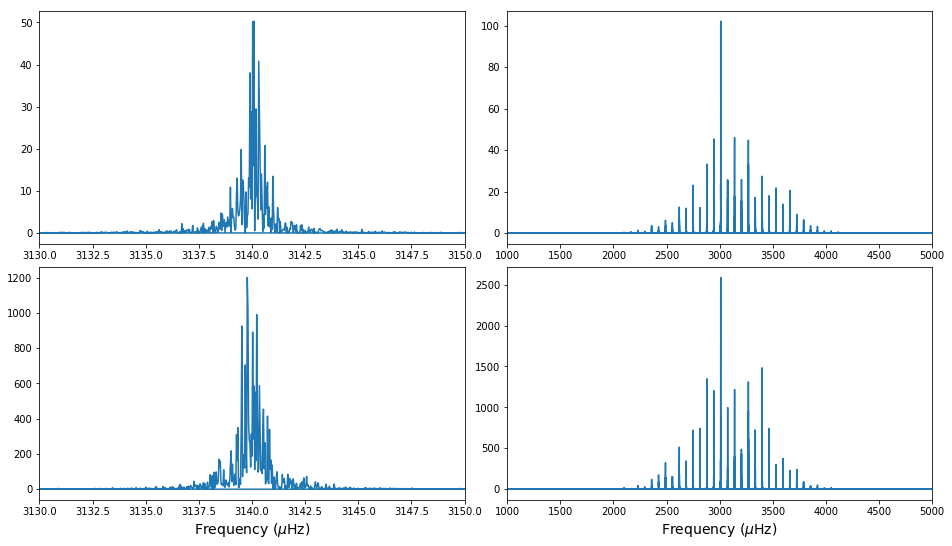

In [40]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,9), gridspec_kw={'hspace':0.1, 'wspace':0.1})
ax1.plot(fs*1e6, fft_gp_onemode)
ax2.plot(fs*1e6, fft_gp)
ax1.set_xlim([3130,3150])
ax2.set_xlim([1000,5000])


ax3.plot(fs*1e6, fft_onemode)
ax4.plot(fs*1e6, fft)
ax3.set_xlim([3130,3150])
ax4.set_xlim([1000,5000])

ax3.set_xlabel(r'Frequency ($\mu$Hz)', fontsize=14)
ax4.set_xlabel(r'Frequency ($\mu$Hz)', fontsize=14);